## Getting insights about the model

In the first tutorial we calculated invariant representations of atomic environments and used them for prediction of energies.

But it is always good to have some understanding about the model. In this tutorial it will be shown how to get spectrums of pca along with number of covariants after each transformation.

First of all we need fitted model. This preliminary cell reproduces corresponding part of the first tutorial "constructing machine learning potential: (few hypers are changed)

In [1]:
# cell to wrap in collapsible in future

# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz

import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge

HARTREE_TO_EV = 27.211386245988
train_subset = "0:10000"    #input for ase.io.read command
test_subset = "10000:15000"     #input to ase.io.read command
environments_for_fitting = 1000    #number of environments to fit nice transfomers
grid =  [150, 200, 350, 500, 750, 1000,
         1500, 2000, 3000, 5000, 7500, 10000] #for learning curve

#HYPERS for librascal spherical expansion coefficients
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}

#our model:
def get_nice():
    return StandardSequence([StandardBlock(ThresholdExpansioner(num_expand = 150),
                                              CovariantsPurifierBoth(max_take = 10),
                                                  IndividualLambdaPCAsBoth(n_components = 50),
                                                 ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                                 InvariantsPurifier(max_take = 50),
                                                  InvariantsPCA(n_components = 200)),
                             StandardBlock(ThresholdExpansioner(num_expand = 150),
                                              CovariantsPurifierBoth(max_take = 10),
                                                  IndividualLambdaPCAsBoth(n_components = 50),
                                                 ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                                 InvariantsPurifier(max_take = 50),
                                                  InvariantsPCA(n_components = 200)),
                            StandardBlock(ThresholdExpansioner(num_expand = 150),
                                              CovariantsPurifierBoth(max_take = 10),
                                                  IndividualLambdaPCAsBoth(n_components = 50),
                                                  ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 50),
                                                 InvariantsPCA(n_components = 200))
                                   ],
                            initial_scaler = InitialScaler(mode = 'signal integral',
                                                           individually = True)
                          )


train_structures = ase.io.read('methane.extxyz', 
                         index = train_subset)

test_structures = ase.io.read('methane.extxyz', 
                         index = test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_spherical_expansion(train_structures, HYPERS, all_species)



test_coefficients = get_spherical_expansion(test_structures, HYPERS, all_species)

#individual nice transformers for each atomic specie in the dataset
nice = {}
for key in train_coefficients.keys():
    nice[key] = get_transformer()
    
for key in train_coefficients.keys():
    nice[key].fit(train_coefficients[key][:environments_for_fitting])

--2020-10-12 00:53:40--  https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528
Resolving archive.materialscloud.org (archive.materialscloud.org)... 148.187.96.41
Connecting to archive.materialscloud.org (archive.materialscloud.org)|148.187.96.41|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1602456880&Signature=0VCx86AIK1v7hnHkwCf%2Bp7TF%2ByI%3D&AWSAccessKeyId=ee64314446074ed3ab5f375a522a4893 [following]
--2020-10-12 00:53:40--  https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1602456880&Signature=0VCx86AIK1v7hnHkwCf%2B

100%|██████████| 2/2 [00:00<00:00, 62.63it/s]
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local

As it was discussed in the first tutorial ThresholdExpansioner sorts all pairs of inputs by their pairwise importances and after that produces the output only for fixed number of most important pairs. This number is controlled by num_expand. 

But, there are two reasons, why real number of covariants after ThresholdEpansioner might be different from the speciefied one. 
1) some pairs of input covariants produce features not to all lambda channels. Particularly, pair of inpur covariants with some l1 and l2 produces covariants only to lambda channels where |l1 - l2| <= lambda <= l1 + l2. Thus, real number of features after ThresholdExpanioner would be smaller than specified one in num_expand.

2) Pairwise importances can have a lot of collisions. For instance it is impossible to select such threshold to filter out exactly 3 pairs from the set of pairs with the following importances [1, 1, 2, 2]. It is possible to filter out either 0, either 2, either 4, but not exactly 3. 

Thus, it is good idea to have possibility to have a look at the actual amount of intermediate features.

StandardSequence has method get_intermediat_shapes(). It returns intermediate shapes in the form of nested dictionary:

In [2]:
intermediate_shapes = nice[1].get_intermediate_shapes()

for key in intermediate_shapes.keys():
    print(key, ':',  intermediate_shapes[key], end = '\n\n\n')

after initial transformer : [[10, 0, 10, 0, 10, 0], [0, 10, 0, 10, 0, 10]]


after initial pca : [[10, 0, 10, 0, 10, 0], [0, 10, 0, 10, 0, 10]]


block nu = 1 -> nu = 2 : {'after covariants expansioner': [[52, 51, 121, 103, 131, 94], [0, 92, 82, 130, 104, 114]], 'after covariants purifier': [[52, 51, 121, 103, 131, 94], [0, 92, 82, 130, 104, 114]], 'after covariants pca': [[50, 50, 50, 50, 50, 50], [0, 50, 50, 50, 50, 50]], 'after invariants expansioner': 300, 'after invariants purifier': 300, 'after invariants pca': 200}


block nu = 2 -> nu = 3 : {'after covariants expansioner': [[33, 51, 79, 88, 87, 73], [12, 65, 76, 88, 88, 80]], 'after covariants purifier': [[33, 51, 79, 88, 87, 73], [12, 65, 76, 88, 88, 80]], 'after covariants pca': [[33, 50, 50, 50, 50, 50], [12, 50, 50, 50, 50, 50]], 'after invariants expansioner': 300, 'after invariants purifier': 300, 'after invariants pca': 200}


block nu = 3 -> nu = 4 : {'after covariants expansioner': [[19, 49, 57, 72, 66, 62], [25, 49, 6

spectrums of pcas can be accessed in the following way: 
(convenient getters will be inserted in the next version of NICE)

nu:  1


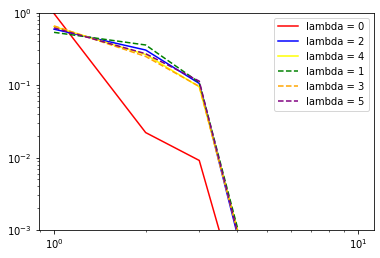

nu:  2


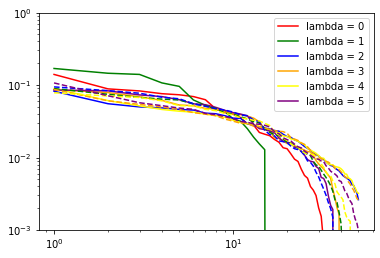

nu:  3


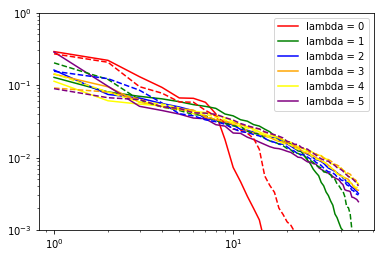

nu:  4


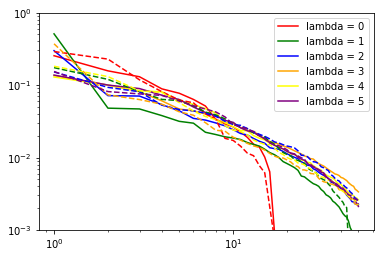

In [3]:
def proper_log_plot(array, *args, **kwargs):
    '''avoiding log(0)'''
    plt.plot(np.arange(len(array)) + 1, array, *args, **kwargs)
    plt.ylim([1e-3, 1e0])

colors = ['r', 'g', 'b', 'orange', 'yellow', 'purple']

print("nu: ", 1)
for i in range(6): # loop over lambda channels
    if (nice[6].initial_pca_ is not None):
        if (nice[6].initial_pca_.even_pca_.pcas_[i] is not None):
            proper_log_plot(nice[6].initial_pca_.even_pca_.pcas_[i].importances_,
                            color = colors[i], label = "lambda = {}".format(i))


for i in range(6): # loop over lambda channels
    if (nice[6].initial_pca_ is not None):
        if (nice[6].initial_pca_.odd_pca_.pcas_[i] is not None):
            proper_log_plot(nice[6].initial_pca_.odd_pca_.pcas_[i].importances_,
                            '--', color = colors[i], label = "lambda = {}".format(i))

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
    
for nu in range(len(nice[6].blocks_)): # loop over body orders
    print("nu: ", nu + 2)
    for i in range(6): # loop over lambda channels
        if (nice[6].blocks_[nu].covariants_pca_ is not None):
            if (nice[6].blocks_[nu].covariants_pca_.even_pca_.pcas_[i] is not None):
                proper_log_plot(nice[6].blocks_[nu].covariants_pca_.even_pca_.pcas_[i].importances_, color = colors[i], label = "lambda = {}".format(i))
        
    
    for i in range(6): # loop over lambda channels
        if (nice[6].blocks_[nu].covariants_pca_ is not None):
            if (nice[6].blocks_[nu].covariants_pca_.odd_pca_.pcas_[i] is not None):
                proper_log_plot(nice[6].blocks_[nu].covariants_pca_.odd_pca_.pcas_[i].importances_, '--', color = colors[i])
    
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()

(checks if pca instance is None are needed since it would be None if number of features for corresponding lambda channel would be zero after expansion step)

inner class for single Lambda channel inherits from sklearn.decomposition.TruncatedSVD (PCA without centering the data, which would break covariant transformation). Thus, in addition to .importances_, .explained_variance_ and .explained_variance_ratio_ are also accesible. 

importances_ (which are used by subsequent TresholdExpansioners) are explained_variance_ normalized not to variance of input as explained_variance_ratio_, but to variance of output:

In [17]:
print(np.sum(nice[6].blocks_[1].\
             covariants_pca_.even_pca_.pcas_[2].explained_variance_))
print(np.sum(nice[6].blocks_[1].\
             covariants_pca_.even_pca_.pcas_[2].explained_variance_ratio_))
print(np.sum(nice[6].blocks_[1].\
             covariants_pca_.even_pca_.pcas_[2].importances_))

0.015553507472993076
0.979846667528322
1.0
